<a href="https://www.kaggle.com/paulwightmore/ai-synth?scriptVersionId=86757701" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow.keras as keras

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from typing import Iterable, Mapping


Question: What would it take to create an AI based synth.
Answer: I have no idea, but let's give it a shot.

**Part I - Waveform characteristics**

Given a fixed size waveform, can we use AI to categorise the input and to provide a set of outputs representing the waveforms characteristics?

What characteristics?

- Type (sine, sawtooth, square)
- Phase (0.0 0 degs, 1.0 180 degs)
- Attack (0.0 not attack - whatever that means, 1.0 instant on)
- Volume/power
- Decay (0.0 does not decay, 1.0 instant off)
- Harmonics (various standard harmonics e.g. 3rd_harmonic - 0.0 harmonic does not exist, 1.0 harmonic at full intensity)

**Part II - Waveform generation**

Given a set of user controlable characteristics produce a suitable waveform - this could be done, for example, by using sliders for assigning the amount by which a characteristic is present in the output waveform.

**Part III - ???**

???

...some time later...

**Part IV - Fully functional AI generating wavetable synthesizer**

...some more time later...

**Part V - Generate waveform parameters from real instrument samples**

Analyse a sample of a real instrument in order to generate a set of characteristics that allows the sample to be regenerated as closely as the model will allow (given an abundance of additional parameters, temporal capabilities).

What to make your new piano sample more synthetic? No problem just adjust the sine and sawtooth characteristic sliders and watch your new waveform transform in near real time.

Disclaimer: I have no intention of seeing this through, maybe I'll play around to see what I can come up with for part I and part II.
Additional disclaimer: I have no professional nor practical experience of neural nets and I am using the above as an exercise in broadaning my experience.

Firstly from previous iterations, there was a need for some knowledge of the current context (e.g. what is the global sample rate) and in addition to this some helper functions for manipulating sample and time conversions; more importantly some of these functions provided the ability to be implemented as [generators]<sup>*</sup>.(https://realpython.com/introduction-to-python-generators/)

<sup>*</sup>My goal is to avoid passing around huge arrays of numbers where ever possible.

In [2]:
class context:
    def __init__(self, sample_rate: int):
        self.sample_rate = sample_rate
        
    def __str__(self):
        return f'context(sample_rate: {self.sample_rate})'
    
    #def sample_rate(self):
    #    return self.sample_rate
    
class sample_context_helper:
    def __init__(self, context: context):
        self.context = context
    
    def time_range(self, t1: float, t2: float, t_steps: int):
        dt = (t2 - t1) / t_steps
        for s in range(0, t_steps):
            yield t1 + s * dt
        
    def sample_count_to_timespan(self, sample_count: int): 
        return float(sample_count) / float(self.context.sample_rate)
        
    def sample_count_to_time_range(self, sample_count: int, sample_offset: int = 0):
        for s in range(sample_offset, (sample_count + sample_offset)):
            yield s / self.context.sample_rate
            
    def timespan_to_sample_count(self, timespan: float): 
        return int(0.5 + timespan * self.context.sample_rate)
    
    def timespan_to_time_range(self, timespan: float, time_offset: float = 0.0):
        sample_count = self.timespan_to_sample_count(timespan)
        sample_count += self.timespan_to_sample_count(time_offset)
        return self.sample_count_to_time_range(sample_count)

ctx = context(sample_rate=48)

print(ctx)

context(sample_rate: 48)


Let's quickly test that.

In [3]:
default_step = 0.1;
default_timespan = 1.0;
#default_timespan_range = np.arange(0.0, default_timespan + default_step, default_step);

In [4]:
ctx_hlp = sample_context_helper(ctx)

print(f'1 sec = {ctx_hlp.timespan_to_sample_count(1.0)} samples')
print(f'2.5 sec = {ctx_hlp.timespan_to_sample_count(2.5)} samples')
print(f'48 samples = {ctx_hlp.sample_count_to_timespan(48)} secs')
print(f'120 samples = {ctx_hlp.sample_count_to_timespan(120)} secs')

print("time range of 1 sec to 2.5 sec over 10 steps:")
time_range = np.fromiter(ctx_hlp.time_range(1.0, 2.5, 10), float)
print(time_range)

print("time range of 48 samples:")
time_range = np.fromiter(ctx_hlp.sample_count_to_time_range(48), float)
print(time_range)

print("time range of 1 sec:")
time_range = np.fromiter(ctx_hlp.timespan_to_time_range(1.0), float)
print(time_range)

default_timespan_range = np.fromiter(ctx_hlp.timespan_to_time_range(default_timespan), float)

1 sec = 48 samples
2.5 sec = 120 samples
48 samples = 1.0 secs
120 samples = 2.5 secs
time range of 1 sec to 2.5 sec over 10 steps:
[1.   1.15 1.3  1.45 1.6  1.75 1.9  2.05 2.2  2.35]
time range of 48 samples:
[0.         0.02083333 0.04166667 0.0625     0.08333333 0.10416667
 0.125      0.14583333 0.16666667 0.1875     0.20833333 0.22916667
 0.25       0.27083333 0.29166667 0.3125     0.33333333 0.35416667
 0.375      0.39583333 0.41666667 0.4375     0.45833333 0.47916667
 0.5        0.52083333 0.54166667 0.5625     0.58333333 0.60416667
 0.625      0.64583333 0.66666667 0.6875     0.70833333 0.72916667
 0.75       0.77083333 0.79166667 0.8125     0.83333333 0.85416667
 0.875      0.89583333 0.91666667 0.9375     0.95833333 0.97916667]
time range of 1 sec:
[0.         0.02083333 0.04166667 0.0625     0.08333333 0.10416667
 0.125      0.14583333 0.16666667 0.1875     0.20833333 0.22916667
 0.25       0.27083333 0.29166667 0.3125     0.33333333 0.35416667
 0.375      0.39583333 0.416666

First things first. Let's provide a wave of generating some waveforms in code. From this we can then generate a series of samples and build up a dataset library...

In [5]:
import math
   
class signal_generator:
    def __init__(self, context: context):
        self.context = context
        self.ctx_hlp = sample_context_helper(context)
        
    def _calc_t(self, timepoint: float):
        return timepoint
    
    def _generate_raw_sample(self, t: float):
        return 0.0
    
    def _generate_cooked_sample(self, t: float):
        return self._generate_raw_sample(t)
            
    def generate_sample(self, timepoint: float):
        t = self._calc_t(timepoint)
        return self._generate_cooked_sample(t)
    
    def generate_samples(self, tp1: float, tp2: float):
        sample_count = self.ctx_hlp.timespan_to_sample_count(tp2-tp1)
        t1 = self._calc_t(tp1)
        t2 = self._calc_t(tp2)
        for t in self.ctx_hlp.time_range(t1, t2, sample_count):
            yield self._generate_cooked_sample(t)
            
class waveform_generator(signal_generator):
    def __init__(self, context: context, phase: float):
        super().__init__(context)
        self.phase = phase
    
    def _calc_t(self, timepoint: float):
        return self.phase + timepoint

Set up a basic test environment that will allow us to plot our generator classes

In [6]:
class plot_helper:
    def __init__(self, context: context):
        self.context = context
        self.ctx_hlp = sample_context_helper(context)
        
    def plot_signal(self, generator: signal_generator, timespan = default_timespan, t0 = 0.0, title: str = None):
        samples = np.fromiter(generator.generate_samples(t0, timespan), float)

        time_range = self.ctx_hlp.time_range(t0, timespan, len(samples))
        df = pd.DataFrame(samples, time_range)
        df.plot(title = title)
 
plt = plot_helper(ctx)

Plot the out put of the sine generator

In [7]:
class sine_wave_generator(waveform_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase)
        
    def _generate_raw_sample(self, timepoint: float):
        t = math.fmod(timepoint + self.phase, 1.0)
        return math.sin(2.0 * math.pi * t)


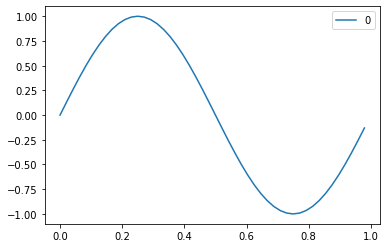

In [8]:
sine_gen = sine_wave_generator(ctx)

plt.plot_signal(sine_gen)

In [9]:
class cosine_wave_generator(sine_wave_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase + 0.25)


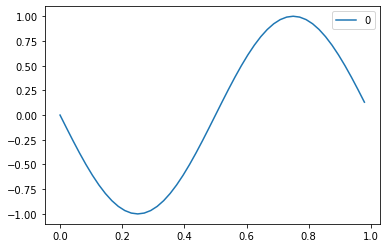

In [10]:
cosine_gen = cosine_wave_generator(ctx)

plt.plot_signal(cosine_gen)

Now let's create a simple square wave generator

In [11]:
class square_wave_generator(waveform_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase)
        
    def _generate_raw_sample(self, timepoint: float):
        t = math.fmod(timepoint + self.phase, 1.0)
        return 1.0 if t < 0.5 else -1.0 

Plot the out put of the square wave generator

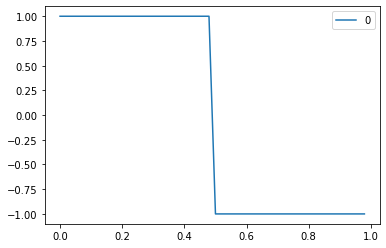

In [12]:
square_gen = square_wave_generator(ctx)

plt.plot_signal(square_gen)

That was pretty straight forward, a sawtooth generator shouldn't be that much more of a stretch.

In [13]:
class sawtooth_wave_generator(waveform_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase)
        
    def _generate_raw_sample(self, timepoint: float):
        t = math.fmod(timepoint + self.phase, 1.0)
        return 2.0 * (t if t < 0.5 else t - 1.0)

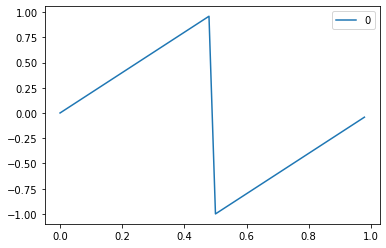

In [14]:
sawtooth_gen = sawtooth_wave_generator(ctx, phase = 0.0)

plt.plot_signal(sawtooth_gen)

We have some generator classes, now let's create a class for generating a series of samples at a given frequency over a given period of time

In [15]:
class tweakable_signal_generator(signal_generator):
    def __init__(self, context: context, frequency: float, amplitude: float, phase: float, bias: float, attenuation: float):
        super().__init__(context)
        self.frequency = frequency
        self.amplitude = amplitude
        self.phase = phase
        self.bias = bias
        self.attenuation = attenuation
        
    def _calc_t(self, timepoint: float):
        return self.phase + timepoint * self.frequency
    
    #def _generate_raw_sample(self, t: float):
    #    return 0.0
    
    def _generate_cooked_sample(self, t: float):
        return self.bias + self.amplitude * self._generate_raw_sample(t)
            
    #def generate_sample(self, timepoint: float):
    #    t = self._calc_t(timepoint)
    #    return self._generate_cooked_sample(t)
    
    #def generate_samples(self, timespan: float):
    #    #amplitude = 1.0 - self.attenuation
    #    t1 = self._calc_t(0)
    #    t2 = self._calc_t(timespan)
    #    sample_count = self.ctx_hlp.timespan_to_sample_count(timespan)
    #    for t in self.ctx_hlp.time_range(t1, t2, sample_count):
    #        yield self._generate_cooked_sample(t)
    
    
class waveform_signal_generator(tweakable_signal_generator):
    def __init__(self, context: context, generator: waveform_generator, frequency: float, amplitude: float = 1.0, phase: float = 0.0, bias: float = 0.0, attenuation: float = 0.0):
        super().__init__(context, frequency, amplitude, phase, bias, attenuation)
        self.generator = generator
        
    def _generate_raw_sample(self, t: float):
        return self.generator.generate_sample(t)


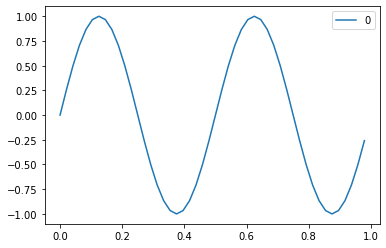

In [16]:
sine_sig_gen_2hz = waveform_signal_generator(ctx, sine_gen, frequency = 2.0)

plt.plot_signal(sine_sig_gen_2hz)


Test sine wave again, this time with a phase shift applied at the signal generator level

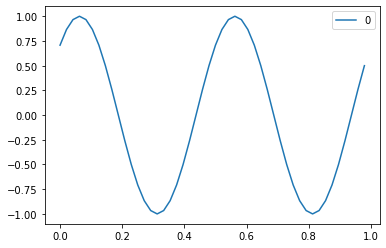

In [17]:
sine_sig_gen_2hz_45degs = waveform_signal_generator(ctx, sine_gen, frequency = 2.0, phase = 0.125)

plt.plot_signal(sine_sig_gen_2hz_45degs)

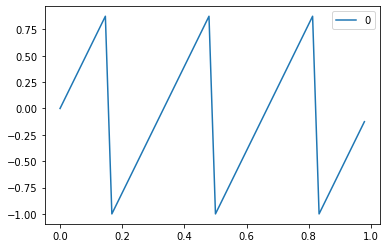

In [18]:
saw_sig_gen_3hz = waveform_signal_generator(ctx, sawtooth_gen, frequency = 3.0)

plt.plot_signal(saw_sig_gen_3hz)

By adding attenuation and bias, we should be able to push a square wave from -1.0 => 1.0 into the 0.0 => 1.0 range

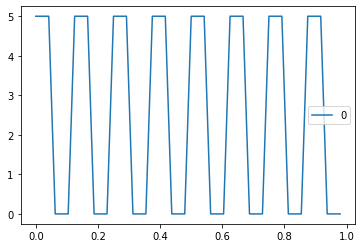

In [19]:
clock_sig_gen_5hz = waveform_signal_generator(ctx, square_gen, frequency = 8.0, amplitude = 2.5, bias = 2.5)

plt.plot_signal(clock_sig_gen_5hz)

Okay, that's the basic signal generation in place. We have a method for creating various pure signals. At somepoint however we may want to start feeding more complex signals through out training program; the most prominent in my mind is how to provide support for harmonics.

We can achieve a more complex signal by mixing<sup>*</sup> multiple signals together...

<sup>*</sup> need to find a more suitable technical term (compositing?)

In [20]:
class compositing_signal_generator(tweakable_signal_generator):
    def __init__(self, context: context, generators: Iterable[signal_generator], frequency: float = 1.0, amplitude: float = 1.0, phase: float = 0.0, bias = 0.0, attenuation: float = 0.0):
        super().__init__(context, frequency, amplitude, phase, bias, attenuation)
        self.generators = generators
        
    def _generate_raw_sample(self, t: float):
        sum = 0.0
        for generator in self.generators:
            sum += generator.generate_sample(t)
        return sum
    

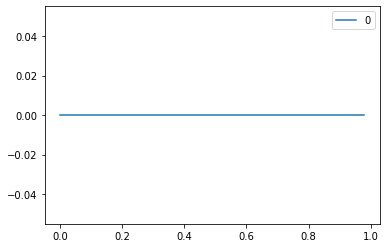

In [21]:
null_signal_generator = compositing_signal_generator(ctx, [])

plt.plot_signal(null_signal_generator)

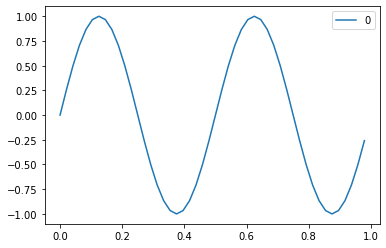

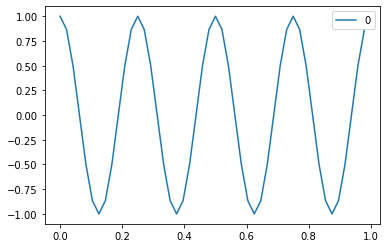

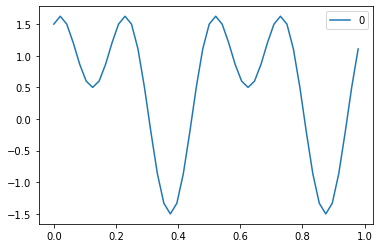

In [22]:
gen1 = waveform_signal_generator(ctx, sine_gen, frequency = 2.0, attenuation = 0.1)
gen2 = waveform_signal_generator(ctx, sine_gen, frequency = 4.0, attenuation = 0.3, phase = 0.25)
comp2_signal_generator = compositing_signal_generator(ctx, [gen1, gen2], bias = 0.5)

plt.plot_signal(gen1)
plt.plot_signal(gen2)
plt.plot_signal(comp2_signal_generator)

My original plan was to somehow use the above generators to generate data tables for storing in some form of overly complicated JSON based data structure. However, as the generators are here and available to use, I may as well store the characteristics of various wave formation in a CSV and then dynamically generate the waveforms required for further processing.

In [23]:
class waveform_generator_factory:
    def __init__(self, context: context):
        self.context = context
        self.generators = {
             'sine': sine_wave_generator,
             'cosine' : cosine_wave_generator,
             'square' : square_wave_generator,
             'sawtooth' : sawtooth_wave_generator}
            
    def create_generator(self, type: str) -> waveform_generator:
        return self.generators[type](self.context)
            
        
class waveform_signal_generator_factory:
    def __init__(self, context: context, wgf: waveform_generator_factory, data: pd.DataFrame):
        self.context = context
        self.wgf = wgf
        self.data = data
        
    def _create_signal_generator(self, data: pd.Series) -> signal_generator:
        type = data['type']     
        frequency = data.get('frequency' , 0.0)
        amplitude = data.get('amplitude' , 1.0)
        phase = data.get('phase' , 0.0) / 360.0 # degs to revolutions
        bias = data.get('bias' , 0.0)
        generator = self.wgf.create_generator(type)
        
        return waveform_signal_generator(self.context, generator, frequency, amplitude, phase, bias)
    
    def create_signal_generator(self, name: str) -> signal_generator:
        row = self.data[self.data['name'] == name].iloc[0]
        return self._create_signal_generator(row)
            
        
    def create_signal_generators(self) -> Mapping[str, signal_generator]:
        sig_gens = {}
        for index, row in self.data.iterrows():
            name = row['name']
            sig_gens[name] = self._create_signal_generator(row)
            
        return sig_gens

In [24]:
df = pd.DataFrame(
    [['sine_1hz', 'sine', 1.0, 1.0, 0, 0.0],
     ['sine_1hz_45deg', 'sine', 1.0, 1.0, 45.0, 0.0],
     ['sine_1hz_90deg', 'sine', 1.0, 1.0, 90.0, 0.0],
     ['sine_1hz_135deg', 'sine', 1.0, 1.0, 135.0, 0.0],
     ['sine_1hz_180deg', 'sine', 1.0, 1.0, 180.0, 0.0],
     ['cosine_1hz', 'cosine', 1.0, 1.0, 0.0, 0.0],
     ['sine_3hz', 'sine', 3.0, 1.0, 0.0, 0.0],
     ['sine_3hz_45deg', 'sine', 3.0, 1.0, 45.0, 0.0],
     ['sine_3hz_90deg', 'sine', 3.0, 1.0, 90.0, 0.0],
     ['sine_3hz_135deg', 'sine', 3.0, 1.0, 135.0, 0.0],
     ['sine_3hz_180deg', 'sine', 3.0, 1.0, 180.0, 0.0],
     ['cosine_3hz', 'cosine', 3.0, 1.0, 0, 0.0]],
    columns=['name', 'type', 'frequency', 'amplitude', 'phase', 'bias'])

wgf = waveform_generator_factory(ctx)
wfsg = waveform_signal_generator_factory(ctx, wgf, df)

    

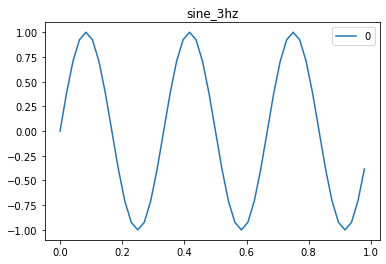

In [25]:
plt.plot_signal(wfsg.create_signal_generator('sine_3hz'), title = 'sine_3hz')

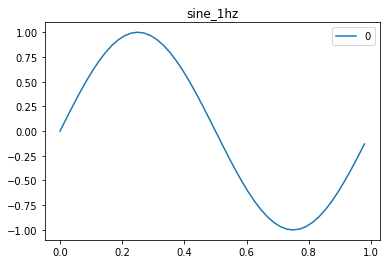

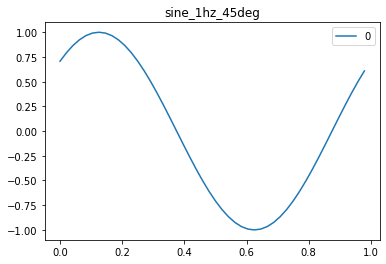

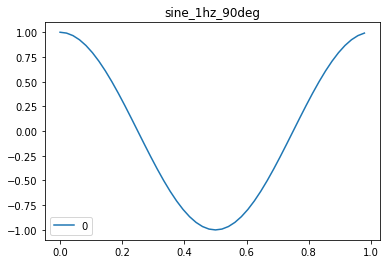

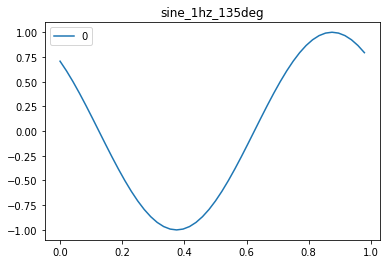

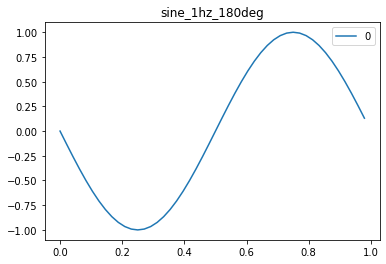

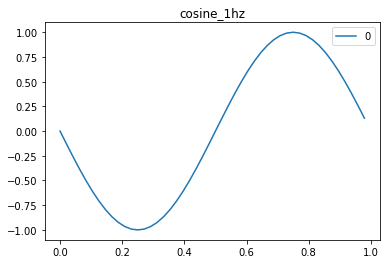

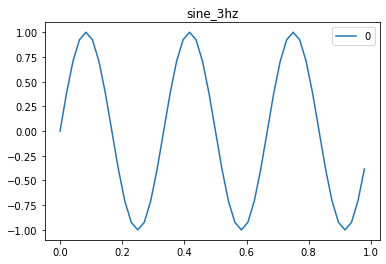

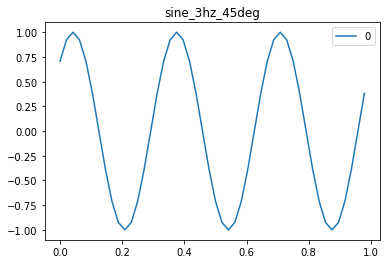

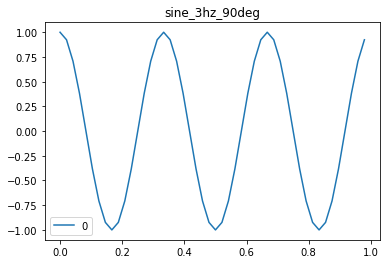

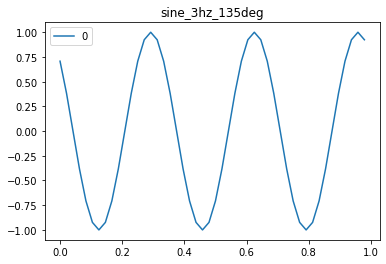

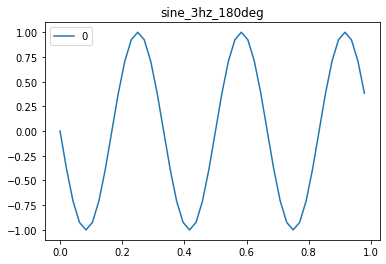

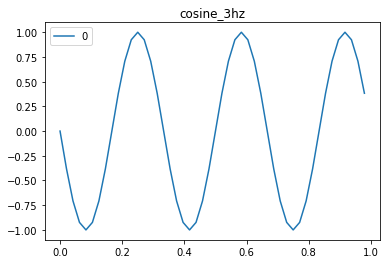

In [26]:
sig_gens = wfsg.create_signal_generators()
for sig_gen_item in sig_gens.items():
    generator = sig_gen_item[1]
    plt.plot_signal(generator, title = sig_gen_item[0])

In [27]:
class composite_signal_generator_factory:
    def __init__(self, context: context, wfsg: waveform_signal_generator_factory, data: pd.DataFrame):
        self.context = context
        self.wfsg = wfsg
        self.data = data
        
    def _create_signal_generator(self, data: pd.Series) -> signal_generator:
        generators = []
        
        signal1Name = data.get('signal1', None)
        if (signal1Name):
            generators.append(self.wfsg.create_signal_generator(signal1Name))
        
        signal2Name = data.get('signal2', None)
        if (signal2Name):
            generators.append(self.wfsg.create_signal_generator(signal2Name))
        
        signal3Name = data.get('signal3', None)
        if (signal3Name):
            generators.append(self.wfsg.create_signal_generator(signal3Name))
        
        signal4Name = data.get('signal4', None)
        if (signal4Name):
            generators.append(self.wfsg.create_signal_generator(signal4Name))
        
        signal5Name = data.get('signal5', None)
        if (signal5Name):
            generators.append(self.wfsg.create_signal_generator(signal5Name))
        
        signal6Name = data.get('signal6', None)
        if (signal6Name):
            generators.append(self.wfsg.create_signal_generator(signal6Name))
        
        return compositing_signal_generator(self.context, generators)
    
    def create_signal_generator(self, name: str) -> signal_generator:
        row = self.data[self.data['name'] == name].iloc[0]
        return self._create_signal_generator(row)
    
    def create_signal_generators(self) -> Mapping[str, signal_generator]:
        sig_gens = {}
        for index, row in self.data.iterrows():
            name = row['name']
            sig_gens[name] = self._create_signal_generator(row)
            
        return sig_gens

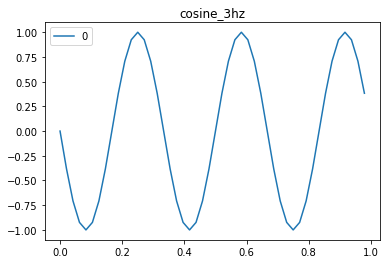

In [28]:
df = pd.DataFrame(
    [['sine_1hz', 'sine_1hz', None, None, None, None],
     ['sine_1hz_45deg', 'sine_1hz_45deg', None, None, None, None],
     ['sine_1hz_90deg', 'sine_1hz_90deg', None, None, None, None],
     ['sine_1hz_135deg', 'sine_1hz_135deg', None, None, None, None],
     ['sine_1hz_180deg', 'sine_1hz_180deg', None, None, None, None],
     ['cosine_1hz', 'cosine_1hz', None, None, None, None],
     ['sine_3hz', 'sine_3hz', None, None, None, None],
     ['sine_3hz_45deg', 'sine_3hz_45deg', None, None, None, None],
     ['sine_3hz_90deg', 'sine_3hz_90deg', None, None, None, None],
     ['sine_3hz_135deg', 'sine_3hz_135deg', None, None, None, None],
     ['sine_3hz_180deg', 'sine_3hz_180deg', None, None, None, None],
     ['cosine_3hz', 'cosine_3hz', None, None, None, None]],
    columns=['name', 'signal1', 'signal2', 'signal3', 'signal4', 'signal5'])

sg = composite_signal_generator_factory(ctx, wfsg, df)

plt.plot_signal(sg.create_signal_generator('cosine_3hz'), title = sig_gen_item[0])


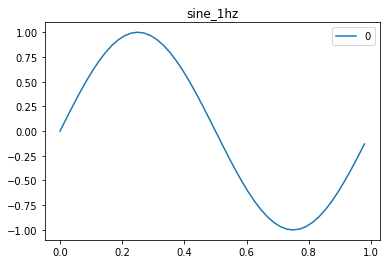

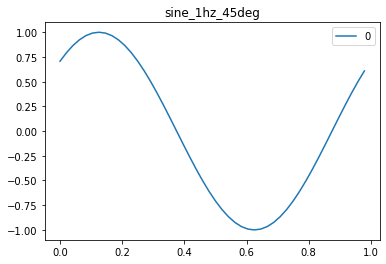

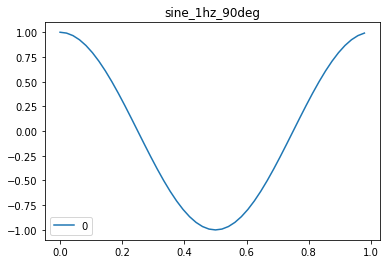

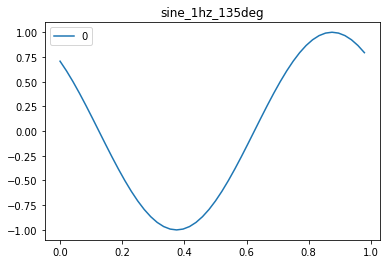

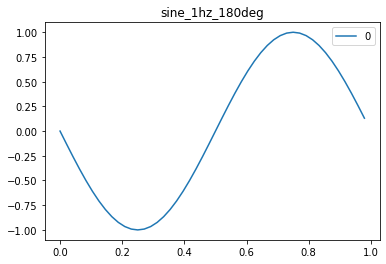

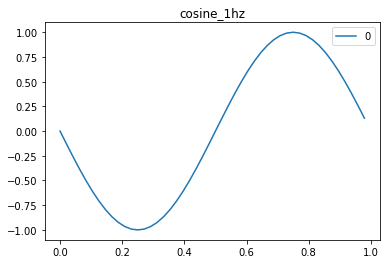

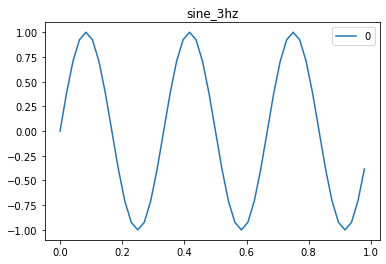

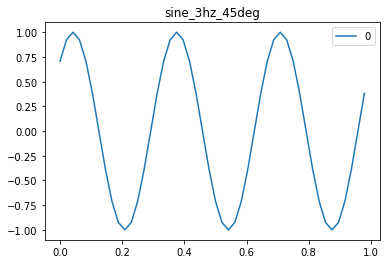

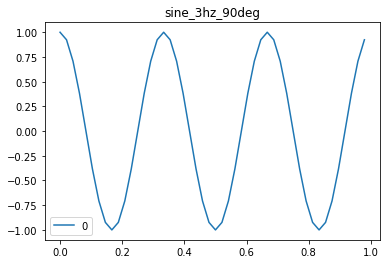

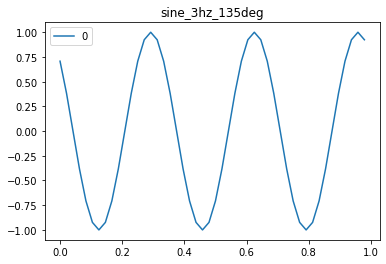

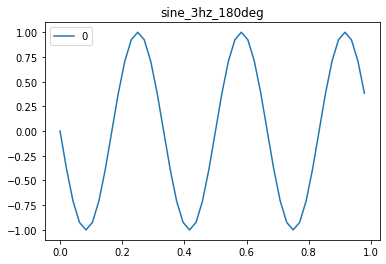

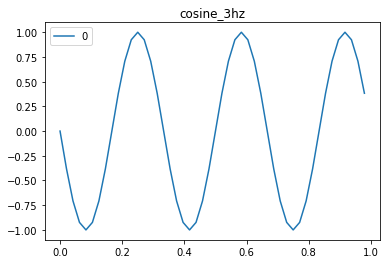

In [29]:
sig_gens = sg.create_signal_generators()
for sig_gen_item in sig_gens.items():
    generator = sig_gen_item[1]
    plt.plot_signal(generator, title = sig_gen_item[0])


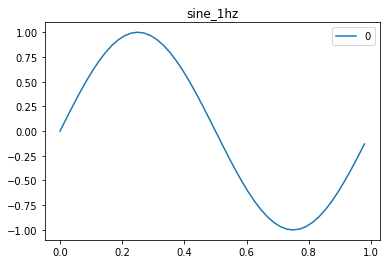

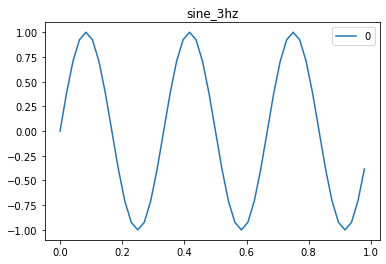

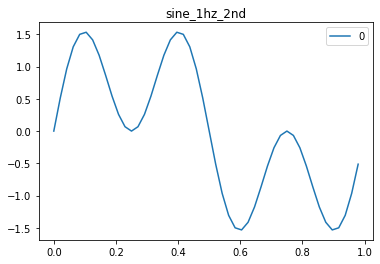

In [30]:
df = pd.DataFrame(
    [['sine_1hz', 'sine_1hz', None, None, None, None],
     ['sine_3hz', 'sine_3hz', None, None, None, None],
     ['sine_1hz_2nd', 'sine_1hz', 'sine_3hz', None, None, None]],
    columns=['name', 'signal1', 'signal2', 'signal3', 'signal4', 'signal5'])

sg = composite_signal_generator_factory(ctx, wfsg, df)

sig_gens = sg.create_signal_generators()
for sig_gen_item in sig_gens.items():
    generator = sig_gen_item[1]
    plt.plot_signal(generator, title = sig_gen_item[0])

TODO: Introduce CNNs, why use CNNs and further more detail the probable use of Keras

- Can use 1 dimensional convolution filter on input signal
- No need to limit signal length and sample rate to a manage NN input nodes
- Support for generators (yay!)

https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial
https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c



Right, lets try to create a custom Keras data generator. I'm simply hacking together and implementation based on the following [Ronseal<sup>TM</sup>](https://en.wikipedia.org/wiki/Does_exactly_what_it_says_on_the_tin) entitled guide [Write your own Custom Data Generator for TensorFlow Keras](https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3)

In [31]:
class WaveformDataGenerator(keras.utils.Sequence):
    def __init__(self, context: context,
                 df,
                 batch_size,
                 input_size=48,
                 shuffle=True):
        self.context = context
        self.ctx_hlp = sample_context_helper(context)
        self.df = df.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_type = df['type'].nunique()
        
        wgf = waveform_generator_factory(self.context)
        self.wfsg = waveform_signal_generator_factory(self.context, wgf, df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            self.wfsg.data = df
    
    def __get_input(self, name, target_size):
        sig_gen = self.wfsg.create_signal_generator(name)
        
        t0 = 0
        timespan = self.ctx_hlp.sample_count_to_timespan(target_size)
        
        return np.fromiter(sig_gen.generate_samples(t0, timespan), float)

    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        name_batch = batches['name']
        type_batch = batches['type']

        X_batch = np.asarray([self.__get_input(name, self.input_size) for name in zip(name_batch)])

        #y0_batch = np.asarray([self.__get_output(y, self.n_name) for y in name_batch])
        y0_batch = np.asarray([self.__get_output(y, self.n_type) for y in type_batch])

        return X_batch, tuple([y0_batch])
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

And now for the important bit

[Convolutional Neural Network (CNN) Tutorial](https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial)

It's at this point that i'm ingorantly copying pasting and tweaking code for processing a 2D image, from the above example, and applying it blindly to a 1D waveform signal.

In [32]:
from tensorflow.keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D

model = Sequential()
#

# 5x1 filter stage
##model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
##                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv1D(filters = 8, kernel_size = 5,padding = 'Same', 
                 activation ='relu'))

#model.add(MaxPool2D(pool_size=(2,2)))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.25))

# 3x1 filter stage
#
#model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
#                 activation ='relu'))
model.add(Conv1D(filters = 16, kernel_size = 3,padding = 'Same', 
                 activation ='relu'))

#model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(MaxPool1D(pool_size=2, strides=2))
model.add(Dropout(0.25))

# fully connected
model.add(Flatten())
model.add(Dense(16, activation = "relu"))  # no. of output layers? was 256 so let's try 16 for input size of 48
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [33]:
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])